**TERCERA PARTE - TRABAJO DE DATOS ,MODELOS Y MACHINE LEARNING** 

**1 - ANÁLISIS DE DATOS**

In [16]:
import pandas                  as pd
import numpy                   as np
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from scipy import stats
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


In [2]:
df=pd.read_csv('Exams/Expanded_data_with_more_features.csv', sep=',', decimal='.', index_col=0)
df.head()

,Gender,EthnicGroup,ParentEduc,LunchType,TestPrep,ParentMaritalStatus,PracticeSport,IsFirstChild,NrSiblings,TransportMeans,WklyStudyHours,MathScore,ReadingScore,WritingScore
0,female,NaN,bachelor's degree,standard,none,married,regularly,yes,3.0,school_bus,< 5,71,71,74
1,female,group C,some college,standard,NaN,married,sometimes,yes,0.0,NaN,5 - 10,69,90,88
2,female,group B,master's degree,standard,none,single,sometimes,yes,4.0,school_bus,< 5,87,93,91
3,male,group A,associate's degree,free/reduced,none,married,never,no,1.0,NaN,5 - 10,45,56,42
4,male,group C,some college,standard,none,married,sometimes,yes,0.0,school_bus,5 - 10,76,78,75


In [3]:
df.isnull().sum()

Gender                    0
EthnicGroup            1840
ParentEduc             1845
LunchType                 0
TestPrep               1830
ParentMaritalStatus    1190
PracticeSport           631
IsFirstChild            904
NrSiblings             1572
TransportMeans         3134
WklyStudyHours          955
MathScore                 0
ReadingScore              0
WritingScore              0
dtype: int64

In [4]:
df.dtypes

Gender                  object
EthnicGroup             object
ParentEduc              object
LunchType               object
TestPrep                object
ParentMaritalStatus     object
PracticeSport           object
IsFirstChild            object
NrSiblings             float64
TransportMeans          object
WklyStudyHours          object
MathScore                int64
ReadingScore             int64
WritingScore             int64
dtype: object

In [5]:
# transformar los objetos a categoricos

df["Gender"] = df["Gender"].astype("category")
df["ParentEduc"] = df["ParentEduc"].astype("category")
df["LunchType"] = df["LunchType"].astype("category")
df["WklyStudyHours"] = df["WklyStudyHours"].astype("category")
df["TestPrep"] = df["TestPrep"].astype("category")
df["PracticeSport"] = df["PracticeSport"].astype("category")
df["EthnicGroup"] = df["EthnicGroup"].astype("category")


In [6]:
# Eliminamos las filas con valores nulos
df.dropna(inplace=True)

In [7]:
# crear la variable target (Score de los alumnos)

df['Score'] = ((df['MathScore'] + df['ReadingScore'] + df['WritingScore'])/3).round(0)
df.head()

# eliminar las variables que no se van a utilizar

df.drop(['MathScore', 'ReadingScore', 'WritingScore'], axis=1, inplace=True)
df.head()

,Gender,EthnicGroup,ParentEduc,LunchType,TestPrep,ParentMaritalStatus,PracticeSport,IsFirstChild,NrSiblings,TransportMeans,WklyStudyHours,Score
2,female,group B,master's degree,standard,none,single,sometimes,yes,4.0,school_bus,< 5,90.0
4,male,group C,some college,standard,none,married,sometimes,yes,0.0,school_bus,5 - 10,76.0
5,female,group B,associate's degree,standard,none,married,regularly,yes,1.0,school_bus,5 - 10,79.0
6,female,group B,some college,standard,completed,widowed,never,no,1.0,private,5 - 10,89.0
7,male,group B,some college,free/reduced,none,married,sometimes,yes,1.0,private,> 10,41.0


Análisis de los datos atipicos

In [8]:
Estadisticas=df['Score'].describe()
Q1 = Estadisticas.loc['25%']
Q3 = Estadisticas.loc['75%']
IQR = Q3 - Q1
print(IQR)

21.0


In [9]:
valores_atipicos=(df['Score']< (Q1 - 1.5 * IQR)) | (df['Score'] > (Q3 + 1.5 * IQR))
df[valores_atipicos].describe()

,NrSiblings,Score
count,62.000000,62.000000
mean,2.145161,21.322581
std,1.389029,3.651966
min,0.000000,9.000000
25%,1.000000,20.000000
50%,2.000000,22.000000
75%,3.000000,24.000000
max,7.000000,26.000000


In [10]:
df.shape

(19243, 12)

In [11]:
df = pd.get_dummies(df, columns=["Gender","EthnicGroup","LunchType","TestPrep","ParentMaritalStatus","IsFirstChild","TransportMeans"])

Ordeno las variables segun caracteristicas , como la actividad fisica, el nivel de educacion de los padres y las horas de estudio

In [12]:
# variable con conversion de string a numerico con metedo ordinal

df['PracticeSport'] = df['PracticeSport'].replace({'never':0, 'sometimes':1,'regularly':2})

In [13]:
df['WklyStudyHours'] = df['WklyStudyHours'].replace({'< 5':0, '5 - 10':1,'> 10':2})

In [14]:
df['ParentEduc'] = df['ParentEduc'].replace({'some college':0, 'some high school':1,'high school':2,"associate's degree":3,"bachelor's degree":4,"master's degree":5}) # escala de educacion de los padres

In [15]:
df.head()

,ParentEduc,PracticeSport,NrSiblings,WklyStudyHours,Score,Gender_female,Gender_male,EthnicGroup_group A,EthnicGroup_group B,EthnicGroup_group C,...,TestPrep_completed,TestPrep_none,ParentMaritalStatus_divorced,ParentMaritalStatus_married,ParentMaritalStatus_single,ParentMaritalStatus_widowed,IsFirstChild_no,IsFirstChild_yes,TransportMeans_private,TransportMeans_school_bus
2,5,1,4.0,0,90.0,1,0,0,1,0,...,0,1,0,0,1,0,0,1,0,1
4,0,1,0.0,1,76.0,0,1,0,0,1,...,0,1,0,1,0,0,0,1,0,1
5,3,2,1.0,1,79.0,1,0,0,1,0,...,0,1,0,1,0,0,0,1,0,1
6,0,0,1.0,1,89.0,1,0,0,1,0,...,1,0,0,0,0,1,1,0,1,0
7,0,1,1.0,2,41.0,0,1,0,1,0,...,0,1,0,1,0,0,0,1,1,0


**VARIABLES Y ELECCIÓN DE MODELOS**

**Utilizo la seleccion de variables del modelo RFE para entrenar el modelo, ver cual es las mejores para el modelo**

In [20]:
#datos

d1= df.drop(columns=["Score"], axis=1) # feature variable
d2= df["Score"] # target variable

# dividimos los datos en entrenamiento y test

X_train, X_test, y_train, y_test = train_test_split(d1, d2, test_size=0.2 ,random_state=42) 

# creamos el modelo

modelo6 = LinearRegression()

rfe=RFE(modelo6,n_features_to_select=13) # se crea el objeto 

# entrenamos el modelo

rfe.fit(X_train, y_train)

# muestra las variables seleccionadas
seleccion=rfe.support_

variable_fija=1
seleccion[variable_fija]=True 


print("Variables seleccionadas: ", seleccion)

x_train_rfe=X_train.iloc[:,seleccion]
x_test_rfe=X_test.iloc[:,seleccion]

# entrenamos el modelo con las variables seleccionadas

modelo6.fit(x_train_rfe,y_train)

# evaluamos el conjunto de entrenamiento

accuracy= modelo6.score(x_train_rfe,y_train)
print("Accuracy: ", accuracy)

Variables seleccionadas:  [ True  True False  True  True  True  True  True  True  True  True  True
  True  True  True False False False False False False False False]
Accuracy:  0.25058459071785344


**Elijo la cantidad de variables , donde el modelo se comporta mejor, en este caso 13 variables de las 23 totales**

In [21]:
df.columns

Index(['ParentEduc', 'PracticeSport', 'NrSiblings', 'WklyStudyHours', 'Score',
       'Gender_female', 'Gender_male', 'EthnicGroup_group A',
       'EthnicGroup_group B', 'EthnicGroup_group C', 'EthnicGroup_group D',
       'EthnicGroup_group E', 'LunchType_free/reduced', 'LunchType_standard',
       'TestPrep_completed', 'TestPrep_none', 'ParentMaritalStatus_divorced',
       'ParentMaritalStatus_married', 'ParentMaritalStatus_single',
       'ParentMaritalStatus_widowed', 'IsFirstChild_no', 'IsFirstChild_yes',
       'TransportMeans_private', 'TransportMeans_school_bus'],
      dtype='object')

identifico las variables seleccionadas por el modelo RFE

In [22]:
df_seleccion = df.drop(columns=['Score'], axis=1).columns[seleccion]
df_seleccion

Index(['ParentEduc', 'PracticeSport', 'WklyStudyHours', 'Gender_female',
       'Gender_male', 'EthnicGroup_group A', 'EthnicGroup_group B',
       'EthnicGroup_group C', 'EthnicGroup_group D', 'EthnicGroup_group E',
       'LunchType_free/reduced', 'LunchType_standard', 'TestPrep_completed',
       'TestPrep_none'],
      dtype='object')

Creo un nuevo dataframe con las variables seleccionadas

In [23]:
df_new = df[df_seleccion]
df_new.head()

,ParentEduc,PracticeSport,WklyStudyHours,Gender_female,Gender_male,EthnicGroup_group A,EthnicGroup_group B,EthnicGroup_group C,EthnicGroup_group D,EthnicGroup_group E,LunchType_free/reduced,LunchType_standard,TestPrep_completed,TestPrep_none
2,5,1,0,1,0,0,1,0,0,0,0,1,0,1
4,0,1,1,0,1,0,0,1,0,0,0,1,0,1
5,3,2,1,1,0,0,1,0,0,0,0,1,0,1
6,0,0,1,1,0,0,1,0,0,0,0,1,1,0
7,0,1,2,0,1,0,1,0,0,0,1,0,0,1


Cree el 'df_new', que son las variables elegidas por el modelo RFE, que segun la correlaccion de las variables, son las que mas influyen en el modelo.

**PCA - Variables sintéticas**

In [43]:
#variables sinteticas con pca

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
#importar sns
import seaborn as sns
import matplotlib.pyplot as plt

X1=df_new
#X1 = df.drop(columns=['Score'], axis=1)
y1 = df['Score']


pca = PCA(n_components=7)
pca.fit(df_new)
x_pca = pca.transform(df_new)

print("original shape:   ", df_new.shape)
print("transformed shape:", x_pca.shape)
loadings=pca.components_
component_1=loadings[0,:]
component_2=loadings[1,:]

print("Componente 1: ", component_1)
print("Componente 2: ", component_2)

#pca_tabla=pd.DataFrame(x_pca)
#print(pca_tabla)

# separamos las variables predictoras de la variable objetivo

X_train, X_test, y_train, y_test = train_test_split(x_pca, y1, test_size=0.3)

# creamos el modelo

modelo2 = LinearRegression()

# entrenamos el modelo

modelo2.fit(X_train, y_train)

# hacemos la prediccion
y_pred = modelo2.predict(X_test)

# calculamos el error cuadratico medio

r2b= r2_score(y_test, y_pred)

print("El R2 del modelo es: ", r2b)


original shape:    (19243, 14)
transformed shape: (19243, 7)
Componente 1:  [ 9.99932171e-01 -7.07823952e-03 -2.70647239e-03 -1.12204310e-03
  1.12204310e-03 -1.07717889e-03  8.20611770e-04  2.27380536e-03
 -8.11201842e-04 -1.20603640e-03  5.58719833e-03 -5.58719833e-03
 -1.44201379e-03  1.44201379e-03]
Componente 2:  [-0.00204484 -0.08127453  0.06789214 -0.70032513  0.70032513  0.00129244
  0.0026905  -0.01093792  0.00790889 -0.00095391 -0.00599257  0.00599257
 -0.06167053  0.06167053]
El R2 del modelo es:  0.22377179247402057


1- Veo los pesos de cada componente principal, no tiene mucho peso cada variable, pero se observa que las variables que mas peso tienen son las que se seleccionaron en el modelo RFE

2- De las variables generadas elegidas por RFE, que el optimo , segun pruebas es 14. Aplico PCA en esas variables y lo reduzco a 7 componentes principales para disminuir la 
dimensionalidad.

Pruebas de modelos

**Modelo de Regresión polimonial** Probando el siguiente modelo con un degree de 3, si aumento mas la cantidad de degree, el modelo se sobreajusta y no generaliza bien y tarda mucho en 
entrenar.

El R2 del modelo es:  0.2770726618388364


<Axes: xlabel='Score'>

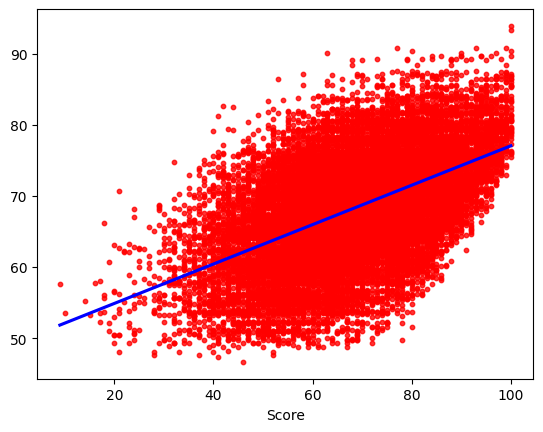

In [26]:
poly_features = PolynomialFeatures(degree=3)
x_poly = poly_features.fit_transform(x_pca)
model10=LinearRegression()
model10.fit(x_poly, y1)

# hacemos la prediccion

y_pred_poly = model10.predict(x_poly)

# calculamos el error cuadratico medio

r2c= r2_score(y1, y_pred_poly)


print("El R2 del modelo es: ", r2c)

# grafico de regresion polinomial

sns.regplot(x=y1, y=y_pred_poly, color="g", ci=None, label="Regresion Polinomial", line_kws={'color':'blue'}, scatter_kws={'color':'red', 's':10})

Se observa que el en modelo de regresion polinomial, el modelo se comporta mejor con un degree de 3, con las variables sinteticas generadas por PCA.

Modelo de regresión lineal

In [62]:
from sklearn.linear_model import LinearRegression

x2= df_new # feature variables
y2 = df["Score"] # target variable

# cargamos los datos de entrenamiento

# separamos las variables predictoras de la variable objetivo

X_train, X_test, y_train, y_test = train_test_split(x2, y2, test_size=0.3)

# creamos el modelo
modelo1 = LinearRegression()

# entrenamos el modelo

modelo1.fit(X_train, y_train)

# hacemos la prediccion
y_pred_lin = modelo1.predict(X_test)

# calculamos el error cuadratico medio

r2a= r2_score(y_test, y_pred_lin)

print("El R2 del modelo es: ", r2a)



El R2 del modelo es:  0.2638377832256734


En el modelo de regresion lineal , con las variables de PCA, baja un poco el rendimiento. el cual uso las variables elegidas por el modelo RFE.

Comparo los 2 modelos, el de regresion polinomial y el de regresion lineal, con las variables de PCA y las variables de RFE.

<Axes: xlabel='Score'>

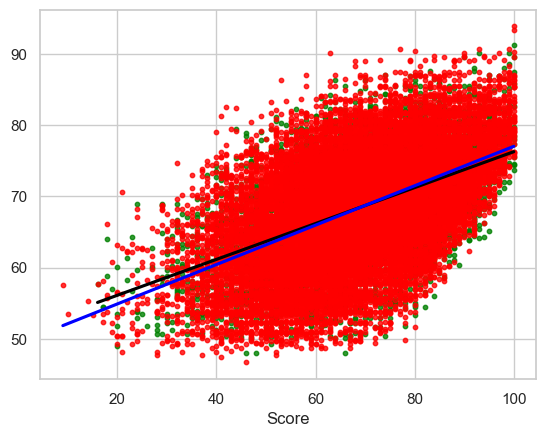

In [49]:
sns.set_theme(style="whitegrid")

# grafico de regresion lineal

sns.regplot(x=y_test, y=y_pred_lin, color="g", ci=None, label="Regresion Lineal", line_kws={'color':'black'}, scatter_kws={'color':'green', 's':10})

# grafico de regresion polinomial

sns.regplot(x=y2, y=y_pred_poly, color="g", ci=None, label="Regresion Polinomial", line_kws={'color':'blue'}, scatter_kws={'color':'red', 's':10})

Ver hiperparametros de los modelos

In [50]:
model12 = Ridge()

# espacio de parametros
espacio_busqueda = {"alpha": [0.0001, 0.00, 0.1, 1, 10, 100, 1000]}

busqueda = GridSearchCV(model12, espacio_busqueda, scoring="r2", cv=5)

busqueda.fit(x2, y2)

print("Mejor parametro: ", busqueda.best_params_)


Mejor parametro:  {'alpha': 10}


In [51]:
model11 = Ridge(alpha=10)

#validacion cruzada

kf = KFold(n_splits=10, shuffle=True, random_state=42)

for train_index, test_index in kf.split(x2):
    x_train, x_test = x2.iloc[train_index], x2.iloc[test_index]
    y_train, y_test = y2.iloc[train_index], y2.iloc[test_index]
    model11.fit(x_train, y_train)
    y_pred = model11.predict(x_test)
    print("R2: ", r2_score(y_test, y_pred))



R2:  0.23794709832969652
R2:  0.25486956079099365
R2:  0.24841317407992636
R2:  0.2594367592372401
R2:  0.2159832342706024
R2:  0.24874183748704848
R2:  0.2839391848386643
R2:  0.2549892572608121
R2:  0.25137826516844597
R2:  0.23342604528168998


Conclusión de perfomance de los modelos, los modelos dan un perfomance cercano al 25 % y 28% . El modelo de regresion polinomial con las variables de PCA, es el que mejor se comporta.